## Import data by using tiingo api key

In [1]:
import requests
import pandas as pd
from datetime import datetime

# Define API key, stock symbol, and date range
api_key = '7a0e057afbaa2d258ad3c407596e30280b62724b'
symbol = 'AAPL'
start_date = '2000-01-01'  # Starting date for the data
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date as end date

# Define the URL for Tiingo API with date range parameters
url = f'https://api.tiingo.com/tiingo/daily/{symbol}/prices?startDate={start_date}&endDate={end_date}'
headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Token {api_key}'
}

# Fetch data
response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)  # Convert to DataFrame

    # Save to CSV
    csv_filename = f'{symbol}_historical_data.csv'
    df.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")
    display(df.head())  # Display the first few rows of the data
else:
    print(f"Failed to retrieve data: {response.status_code}")


Data saved to AAPL_historical_data.csv


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2000-01-03T00:00:00.000Z,111.94,112.50,101.69,104.87,4783900,0.843017,0.847234,0.765824,0.789773,535797335,0.0,1.0
1,2000-01-04T00:00:00.000Z,102.50,110.62,101.19,108.25,4574800,0.771925,0.833076,0.762059,0.815228,512378112,0.0,1.0
2,2000-01-05T00:00:00.000Z,104.00,110.56,103.00,103.75,6949300,0.783221,0.832624,0.775690,0.781338,778322378,0.0,1.0
3,2000-01-06T00:00:00.000Z,95.00,107.00,95.00,106.12,6856900,0.715442,0.805814,0.715442,0.799187,767973567,0.0,1.0
4,2000-01-07T00:00:00.000Z,99.50,101.00,95.50,96.50,4113700,0.749332,0.760628,0.719208,0.726739,460734860,0.0,1.0


In [6]:
import pandas as pd
df = pd.read_csv('AAPL_historical_data.csv')
df.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2000-01-03T00:00:00.000Z,111.94,112.50,101.69,104.87,4783900,0.843017,0.847234,0.765824,0.789773,535797335,0.0,1.0
1,2000-01-04T00:00:00.000Z,102.50,110.62,101.19,108.25,4574800,0.771925,0.833076,0.762059,0.815228,512378112,0.0,1.0
2,2000-01-05T00:00:00.000Z,104.00,110.56,103.00,103.75,6949300,0.783221,0.832624,0.775690,0.781338,778322378,0.0,1.0
3,2000-01-06T00:00:00.000Z,95.00,107.00,95.00,106.12,6856900,0.715442,0.805814,0.715442,0.799187,767973567,0.0,1.0
4,2000-01-07T00:00:00.000Z,99.50,101.00,95.50,96.50,4113700,0.749332,0.760628,0.719208,0.726739,460734860,0.0,1.0


In [16]:
df1 = df.reset_index()['close']
df1.shape

(6254,)

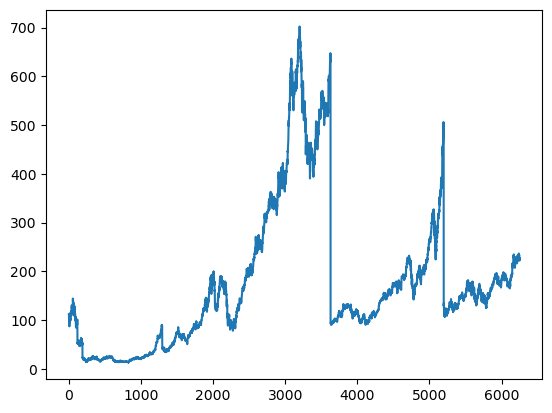

In [12]:
import matplotlib.pyplot as plt
plt.plot(df1)

## LSTM are sensitive to the scale of data. so we apply MinMax Scaler

In [21]:
import numpy as np

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
df1.shape

(6254, 1)

In [29]:
### Now lets do the train test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [31]:
training_size, test_size

(4065, 2189)

In [43]:
import numpy as np
#convert np array to datamatrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [45]:
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [47]:
print(X_train)

[[0.14342942 0.129728   0.13190514 ... 0.11149816 0.10550379 0.10823246]
 [0.129728   0.13190514 0.11884235 ... 0.10550379 0.10823246 0.10762286]
 [0.13190514 0.11884235 0.12537374 ... 0.10823246 0.10762286 0.10631658]
 ...
 [0.14000406 0.1411652  0.14174577 ... 0.12157102 0.11839241 0.12043891]
 [0.1411652  0.14174577 0.14251502 ... 0.11839241 0.12043891 0.12139685]
 [0.14174577 0.14251502 0.14174577 ... 0.12043891 0.12139685 0.12161456]]


In [49]:
print(X_train.shape), print(Y_train.shape)

(3964, 100)
(3964,)


(None, None)

In [51]:
# reshape input to be [samples, timesteps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

In [63]:
### create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

In [65]:
model = Sequential()
model.add(Input(shape=(100, 1)))  # Define input shape here
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [67]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.fit(X_train, Y_train, validation_data=(X_test,Y_test),epochs = 100,batch_size=64, verbose=1)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0237 - val_loss: 0.0014
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0014 - val_loss: 8.6862e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0013 - val_loss: 9.0891e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0010 - val_loss: 8.5645e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.0047e-04 - val_loss: 6.3615e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0016 - val_loss: 5.8778e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 6.0594e-04 - val_loss: 5.6490e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0011 - val_loss: 5.0279e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 2.8736e-04 - val_loss: 4.8633e-04
Epoch 12

In [73]:
#lets do pridiction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [75]:
#transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [79]:
### now we calculate RMSE performance metrics 
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

250.34510967990667

In [81]:
math.sqrt(mean_squared_error(Y_test, test_predict))

188.86390300005206

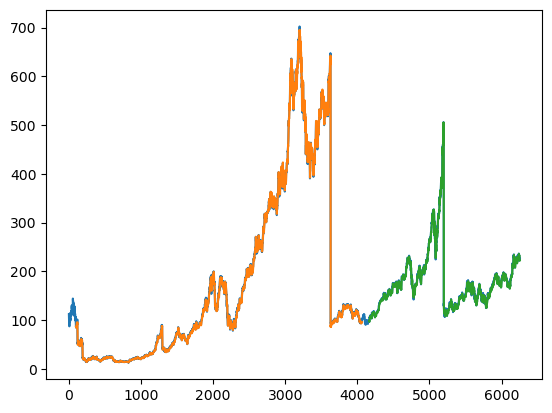

In [85]:
### now we plot the curve of our model pridiction on above graph
#shift trian predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

#plot baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()